<a href="https://colab.research.google.com/github/Akshaychikara/NLP/blob/main/Projects/Chapter02/Chapter01_Project360.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from google.colab import files

#Importing the libraries for building Emotion Classifier
import pandas as pd
#from nltk.corpus import stopwords
#nltk.download('stopwords')
from nltk.stem.wordnet import WordNetLemmatizer
import string
from textblob.classifiers import NaiveBayesClassifier
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import Word
from nltk.util import ngrams
import re
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import sklearn.feature_extraction.text as text
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
import xgboost
from sklearn import decomposition, ensemble
import pandas, numpy, textblob, string
import re
import nltk
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
import math


In [3]:
#uploaded = files.upload()

Saving ISEAR.csv to ISEAR.csv


In [4]:
dataset = pd.read_csv("ISEAR.csv", header=None)
dataset.columns = ['EMOTION', 'TEXT']
#dataset = dataset[['EMOTION', 'TEXT']]
dataset.head()

,EMOTION,TEXT
0,joy,On days when I feel close to my partner and ot...
1,fear,Every time I imagine that someone I love or I ...
2,anger,When I had been obviously unjustly treated and...
3,sadness,When I think about the short time that we live...
4,disgust,At a gathering I found myself involuntarily si...


In [5]:
dataset.info()
# There is no null value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7516 entries, 0 to 7515
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   EMOTION  7516 non-null   object
 1   TEXT     7516 non-null   object
dtypes: object(2)
memory usage: 117.6+ KB


In [6]:
# Perfroming Preprocessing
# -------------------------
from nltk.corpus import stopwords
nltk.download('stopwords')


def preprocess(data):
  # Convert to lower case
  data['TEXT'] = data['TEXT'].apply(str.lower)

  # Remove stop words
  stop_words = stopwords.words('english')
  data['TEXT'] = data['TEXT'].apply(lambda sentense: " ".join(word for word in sentense.split() if word not in stop_words))

  # Correct spelling
  # Not applying str(TextBlob(a).correct()), becasuse it seems to produce incorect results.

  # Get root word
  st = PorterStemmer()
  data['TEXT'] = data['TEXT'].apply(lambda sentense: " ".join(st.stem(word) for word in sentense.split()))

  return data

processed_data = preprocess(dataset)
processed_data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,EMOTION,TEXT
0,joy,day feel close partner friends. feel peac also...
1,fear,everi time imagin someon love could contact se...
2,anger,obvious unjustli treat possibl elucid this.
3,sadness,think short time live relat period life think ...
4,disgust,gather found involuntarili sit next two peopl ...


In [7]:
print(processed_data['EMOTION'].value_counts())
# It seems a well balanced data, except for one case where Emotion is "Guit". It seems misspelled. Will correct it manually.
print(processed_data[processed_data['EMOTION'] == "guit"])
processed_data['EMOTION'] = processed_data['EMOTION'].replace("guit", "guilt")
print("After correcrion..")
print(processed_data['EMOTION'].value_counts())

EMOTION
joy        1092
sadness    1082
anger      1079
fear       1076
shame      1071
disgust    1066
guilt      1049
guit          1
Name: count, dtype: int64
     EMOTION                                               TEXT
7499    guit  hostel, roommat selfish person would avoid any...
After correcrion..
EMOTION
joy        1092
sadness    1082
anger      1079
fear       1076
shame      1071
disgust    1066
guilt      1050
Name: count, dtype: int64


In [8]:
le_obj = preprocessing.LabelEncoder()
processed_data['EMOTION'] = le_obj.fit_transform(processed_data['EMOTION'])
processed_data['EMOTION'].value_counts()

EMOTION
4    1092
5    1082
0    1079
2    1076
6    1071
1    1066
3    1050
Name: count, dtype: int64

In [9]:
# split data for training and testing
X, y = processed_data['TEXT'], processed_data['EMOTION']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y)
print(X_train.shape, X_test.shape)
print(y_train.value_counts(), y_test.value_counts())

(5637,) (1879,)
EMOTION
4    819
5    812
0    809
2    807
6    803
1    800
3    787
Name: count, dtype: int64 EMOTION
4    273
5    270
0    270
2    269
6    268
1    266
3    263
Name: count, dtype: int64


In [10]:
# Feature creation out of text data
cv_obj = CountVectorizer()
cv_X_train = cv_obj.fit_transform(X_train)

cv_X_test = cv_obj.transform(X_test)

In [11]:
tfidf_obj = TfidfVectorizer()
tfidf_X_train = tfidf_obj.fit_transform(X_train)

tfidf_X_test = tfidf_obj.transform(X_test)

In [12]:
# Model creation and selection
def build(model, Xtrain, ytrain, Xtest, ytest):
  # fitting model:
  model.fit(Xtrain,ytrain)
  # make predictions:
  ypred = model.predict(Xtest)
  # model evalution:
  return metrics.accuracy_score(ytest, ypred)




In [14]:
# Initialize different models for calling build (fit and predict and find accuracy)
model_names = ['Linear', 'Naive Bayes', 'SVM', 'Random Forest']
lin = linear_model.LogisticRegression()
nb = naive_bayes.MultinomialNB()
sv_mac = svm.SVC()
forest = ensemble.RandomForestClassifier()
models = [lin, nb, sv_mac, forest]

performance_df = pd.DataFrame(data=0, columns=['CountVector', 'TFIDF'], index=model_names)
performance_df

,CountVector,TFIDF
Linear,0,0
Naive Bayes,0,0
SVM,0,0
Random Forest,0,0


In [15]:
for model_name, model in zip(model_names, models):
  output_cv = build(model, cv_X_train, y_train, cv_X_test, y_test)
  output_tfidf = build(model, tfidf_X_train, y_train, tfidf_X_test, y_test)

  print("Model : ", model_name, " | CV accuracy=", output_cv, " | TdIDF accuracy=", output_tfidf)

  performance_df.loc[model_name]['CountVector'] = round(output_cv*100)
  performance_df.loc[model_name]['TFIDF'] = round(output_tfidf*100)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Model :  Linear  | CV accuracy= 0.5566790846194785  | TdIDF accuracy= 0.5832889835018626
Model :  Naive Bayes  | CV accuracy= 0.552421500798297  | TdIDF accuracy= 0.5694518360830229
Model :  SVM  | CV accuracy= 0.5407131452900479  | TdIDF accuracy= 0.5859499733901011
Model :  Random Forest  | CV accuracy= 0.542309739222991  | TdIDF accuracy= 0.5481639169771155


               CountVector  TFIDF
Linear                  56     58
Naive Bayes             55     57
SVM                     54     59
Random Forest           54     55


<Axes: >

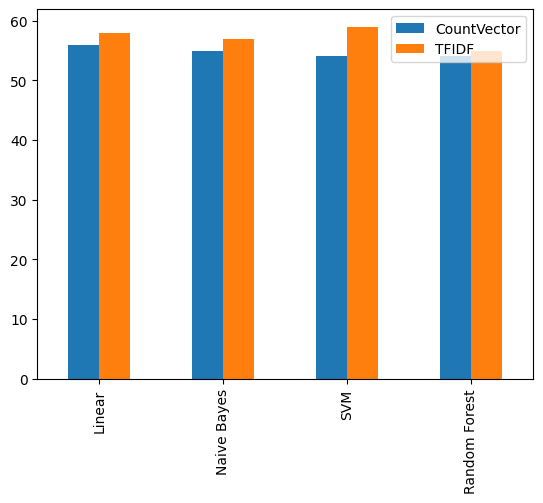

In [16]:
# Comparing performance
print(performance_df)
performance_df.plot(kind = 'bar')

In [17]:
# As performance for Linear model and SVM is highest and same for TFIDF, I will select Linear model for it's simplicity.
linear_classifier = linear_model.LogisticRegression()
linear_classifier.fit(tfidf_X_train, y_train)
y_pred = linear_classifier.predict(tfidf_X_test)

report = classification_report(y_test, y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
print(report)

              precision    recall  f1-score   support

           0       0.46      0.50      0.48       270
           1       0.58      0.62      0.60       266
           2       0.74      0.69      0.71       269
           3       0.54      0.50      0.52       263
           4       0.65      0.71      0.68       273
           5       0.63      0.60      0.62       270
           6       0.49      0.45      0.47       268

    accuracy                           0.58      1879
   macro avg       0.58      0.58      0.58      1879
weighted avg       0.58      0.58      0.58      1879



In [19]:
uploaded = files.upload()

Saving tweets-spuryyc.json to tweets-spuryyc.json


In [29]:
tweet_df = pd.read_json('tweets-spuryyc.json')
tweet_df.columns = ['Text']
tweet_df['Text'].head()

0    RT @wklumpen: Hi @nenshi, I'll be moderating t...
1    This week we look at different transit fare st...
2    We're back with a new article! Looking at some...
3                          New article drops tomorrow!
4    Hi folks, we're taking a summer break. We'll b...
Name: Text, dtype: object

In [30]:
tfidf_tweet = tfidf_obj.transform(tweet_df['Text'])



In [32]:
tweet_df['Emotion'] = linear_classifier.predict(tfidf_tweet)
tweet_df

,Text,Emotion
0,"RT @wklumpen: Hi @nenshi, I'll be moderating t...",2
1,This week we look at different transit fare st...,0
2,We're back with a new article! Looking at some...,0
3,New article drops tomorrow!,4
4,"Hi folks, we're taking a summer break. We'll b...",5
...,...,...
100,"RT @metrocalgary: From critical, to critiquing...",0
101,RT @modacitylife: “It’s not about making all c...,1
102,Calgary Transitway BRT article featured in @me...,6
103,"One way bad, two way good? New article on Calg...",2


In [34]:

tweet_df['sentiment'] = tweet_df['Text'].apply(lambda a: TextBlob(a).sentiment[0] )
def function (value):
  if value['sentiment'] < 0:
    return 'Negative'
  if value['sentiment'] > 0:
    return 'Positive'
  else:
    return 'Neutral'
tweet_df['Sentiment_label'] = tweet_df.apply (lambda a: function(a),axis=1)
tweet_df.tail()

,Text,Emotion,sentiment,Sentiment_label
100,"RT @metrocalgary: From critical, to critiquing...",0,0.250000,Positive
101,RT @modacitylife: “It’s not about making all c...,1,0.500000,Positive
102,Calgary Transitway BRT article featured in @me...,6,0.000000,Neutral
103,"One way bad, two way good? New article on Calg...",2,0.045455,Positive
104,The website has launched! Please consider cont...,0,0.000000,Neutral


In [36]:
Sentiment_df = pd.DataFrame(tweet_df.Sentiment_label.value_counts().reset_index())
Sentiment_df.columns = ['Sentiment', 'Count']
Sentiment_df = pd.DataFrame(Sentiment_df)
Sentiment_df['Percentage'] = 100 * Sentiment_df['Count']/ Sentiment_df['Count'].sum()
Sentiment_Max = Sentiment_df.iloc[0,0]
Sentiment_percent = str(round(Sentiment_df.iloc[0,2],2))
Sentiment_df

,Sentiment,Count,Percentage
0,Positive,55,52.380952
1,Neutral,35,33.333333
2,Negative,15,14.285714


In [41]:
#import chart_studio.plotly as py
import plotly as ply
import cufflinks as cf
from plotly.graph_objs import *
from plotly.offline import *
init_notebook_mode(connected=True)

fig1 = Sentiment_df.iplot(kind='pie',labels='Sentiment',values='Count',textinfo='label+percent', title= 'Sentiment Analysis', world_readable=True,
                    asFigure=True)
ply.offline.plot(fig1,filename="Sentiment.html")

'Sentiment.html'

/usr/local/lib/python3.10/dist-packages/plotly/offline/offline.py:562: UserWarning:

Your filename `Sentiment` didn't end with .html. Adding .html to the end of your file.



'Sentiment.html'